In [2]:
import pythainlp
import gensim

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections
import deepcut

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Sample documents
documents = {'comment':
        ['ซีฟู้ดร้านนี้ถือว่าสดมากมาแบบชิ้นโตๆ เต็มปากเต็มคำ สดใหญ่สะใจ แต่ราคาก็คือโหดร้ายเหลือเกิน บรรยากาศและอาหารที่ได้ ส่วนรสชาติสำหรับเราถือว่าดีงามเลย ปูสดหวานอร่อย ล็อบสเตอร์คือดีสดเนื้อฉ่ำ ซี่โครงหมูก็อร่อย รสชาติอาหารที่นี่ถือว่าปรุงมาได้ดีเลยทีเดียว แต่เอาจริงๆราคาระดับนี้ไปกินร้านอื่นที่คุณภาพใกล้ใกล้กันแต่ราคาย่อมเยาว์กว่าก็มีเยอะอยู่นะเท่าที่เคยกินมา', 'ตั้งแต่ได้กินกุ้งทอดซีเรียลตอนไปเที่ยวสิงคโปร์ก็คือติดใจมาก ตามหามานาน ในไทยหากินไม่ได้เลย ได้กินอีกทีคือฟินสุดๆเมนูซี่โครงหมูอบซอสมอคค่ารสชาติดีมาก มันทั้งหวานเค็มกลมกล่อม รสชาติจัดได้ใจ กินกับข้าวคืออร่อยไม่ไหว', 'มาอีกครั้งเพราะมีเมนูใหม่ Hotpot ชุดนี้ 2999++ ซีฟู้ดสด ปลาเก๋าและหอยเชลคือดีมาก น้ำซุปก็มีให้เลือก น้ำจิ้มซีฟู้ดโอเคนะ แต่กินกับน้ำซุปที่เป็นสูตรเด็ดปูผัดร้านไม่เข้ากัน ติ่มซำก็อราอยมาตรฐาน Jumbo แต่ลิ้นจี่โซดาคือหวานมาก แต่ความสดของอาหารทะเลที่นี่คือดี', 'มื้อกลางวันแบบครอบครัวรับตรุษจีน หรือเพื่อนฝูงการสังสรรค์ ญาติมิตรในเทศกาล กับร้านกว้างขวาง หรือห้องส่วนตัว 6 ท่าน (ต้องทาน 10,000 บาทขึ้นไป) มีพนักงานคอยดูแลกันอย่างดี ร้านอยู่ชั้น G ด้านหลังใกล้ทางออกโรงแรม SIAM KEMPINSKI HOTEL BANGKOK. เมนูแนะนำสั่งได้ตามด้านหน้าเลย ปูผัดผงกะหรี่ พร้อมสั่ง ซาลาเปาทอด คิดราคาเป็นลูก ก๋วยเตี๋ยวผัดซีฟู้ด ปอเปี้ยะซีฟู้ด กุ้ง lobster ในน้ำซุป เนื้อผัดพริกไทยดำ Pudding มะม่วง อร่อยอาหารสด และอาหารรอไม่นานมาก บริการดี', 'ร้าน Jumbo Seafood มาออกบูทที่พารากอนบริเวณหน้า gourmet market โดนจะเน้นขายเมนูติ่มซำพรีเมียมซึ่งมีเมนูให้เลือกไม่เยอะมาก เป็นเมนูพื้นฐานอย่างพวกขนมจีบ ฮะเก๋า ซาลาเปา ราคาก็จะแรงหน่อยแต่ชิ้นใหญ่และใช้วัตถุดิบดี โดยราคาที่เห็นเป็นราคาต่อชิ้น โชคดีวันที่ไปมีส่วนลด 25% พอดีด้วยค่ะ เมนูที่ซื้อ ขนมจีบจัมโบ้ เป็นขนมจีบหมูผสมกุ้ง แต่หมูไม่เยอะมาก แป้งบางไส้แน่น ท้อปด้วยไข่กุ้งเพิ่มความน่าทาน ฮะเก๋ากุ้ง แป้งจะหนากว่าขนมจีบไส้กุ้งสับล้วน ท้อปด้วยไข่กุ้งสีดำและแผ่นทองเพิ่มความหรูหรา ปอเปี๊ยะทอดไส้กุ้งและเห็ดทรัฟเฟิล เป็นปอเปี๊ยะที่ใช้เส้นหมี่หรือเส้นอะไรซักอย่างมาม้วนแล้วทอด คิดว่าทานเลยน่าจะดีสุดเพราะเอากลับมาบ้านถึงจะอบเตาติ๊งก็ยังไม่ฟูกรอบแบะค่อนข้างอมน้ำมัน แต่ไส้ดีกุ้งเป็นชิ้นใหญ่พร้อมความหอมจากทรัฟเฟิลเข้ากันดี', 'ร้านอาหารเจ้าดังจากสิงคโปร์มาเปิดที่ไทยนานมากแล้ว แต่เรายังไม่เคยไปทาน รอบนี้มีโอกาสได้ลองซะที สั่งปูมาหลายจานเลย ใหญ่ สด แต่แอบแกะยากหน่อย เพราะกระดองค่อนข้างแข็ง แต่เค้าก็ทุบมาให้บ้างแล้วนะ เมนูลอบสเตอร์ และปลาก็สดมากเหมือนกัน เมนูของทอดที่เราชอบ กุ้งทอดไข่เค็ม ดีงามมากจ้า ปลานึ่งต่างๆก็ดีมากๆเลย แนะนำ เหมาะกับพาพ่อแม่ไปทาน', 'สิงคโปร์มั้ยละ!! มื้อนี้กับมิตรสหาย หลังจากวนๆ คิดอยู่นาน ว่าจะจีน ญี่ปุ่น ไทย อิตาลี หรือสัญชาติไหนดี สรุปจบที่สิงคโปร์มั้ยละ จัมโบ้ซีฟู้ด สยามพารากอน ร้านนี้อยู่ที่ชั้น G นะคะ ที่นั่งสะดวกสบาย ร้านสะอาดสะอ้าน พนักงานบริการดี เราสั่งเซ็ท 4,999 บาท (ไม่รวม vat และ service นะคะ) ทานกัน 4 คน แทบคลานเลยค่ะ อิ่มมาก รสชาติดีมาก ราคาแรงหน่อย แต่คุ้มค่ะ', 'อาหารซีฟู๊ดชื่อดังจากสิงคโปร์ มาเปิดสาขาที่สยามพารากอน เมนูที่สั่งกลับบ้านจะมี ปูจัมโบ้ผัดซอสพริก ซี่โครงหมูอบซอสมอคค่า กุ้งผัดพริกไทยและเกลือ ข้าวผัดทะเล วัตถุดิบคือดีมาก ปูตัวใหญ่มาก เมนูที่ชอบสุดคงเป็นปูจัมโบ้ปัดซอสพริก ชอบรสชาติของน้ำที่ราดปูเข้มข้นกลมกล่อมไม่เลี่ยน ส่วนเนื้อปูคือแน่นมาก ส่วนซี่โครงหมูอบซอสมอคค่าคือรสชาติแปลก ออกหวานแต่มีกลิ่นกาแฟ แต่ก็ถือว่ารสชาติดี รวมๆคือดีทุกเมนู']}

# doc to pandas df
df = pd.DataFrame(documents)
df.tail()


,comment
3,มื้อกลางวันแบบครอบครัวรับตรุษจีน หรือเพื่อนฝูง...
4,ร้าน Jumbo Seafood มาออกบูทที่พารากอนบริเวณหน้...
5,ร้านอาหารเจ้าดังจากสิงคโปร์มาเปิดที่ไทยนานมากแ...
6,สิงคโปร์มั้ยละ!! มื้อนี้กับมิตรสหาย หลังจากวนๆ...
7,อาหารซีฟู๊ดชื่อดังจากสิงคโปร์ มาเปิดสาขาที่สยา...


In [23]:
custom_combinations = [('ซี', 'ฟู๊ด'), ('ซี', 'ฟู้ด'), ('กลาง', 'วัน')]  # Add your custom word combinations here

stop_word = list(pythainlp.corpus.thai_stopwords())
rm_word = ['',' ','    ','\n', '(', ')', 'ร้าน']

screenword = stop_word + rm_word

def combine_words(words):
    combined = []
    i = 0
    while i < len(words):
        combined_word = words[i]
        for combination in custom_combinations:
            if i < len(words) - 1 and (words[i], words[i + 1]) == combination:
                combined_word = ''.join(combination)
                i += 1
                break
        combined.append(combined_word)
        i += 1
    return combined

def tokenize_n_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize(str(sentence), engine='deepcut')
    words = combine_words(words)
    for i in words:
        if i not in screenword:
            merged = merged + ',' + i
    return merged[1:]

# Example usage
# sentence = "ซีฟู๊ด อร่อยมาก"
# tokenized_result = tokenize_n_space(sentence)
# print(tokenized_result)

In [24]:
df['tokenized'] = df['comment'].apply(lambda x: tokenize_n_space(x))
df.tail()

13/13 [==============================] - 1s 17ms/step


,comment,tokenized
3,มื้อกลางวันแบบครอบครัวรับตรุษจีน หรือเพื่อนฝูง...,"มื้อ,กลางวัน,ครอบครัว,รับตรุษ,จีน,เพื่อนฝูง,สั..."
4,ร้าน Jumbo Seafood มาออกบูทที่พารากอนบริเวณหน้...,"Jumbo Seafood,ออกบูท,พารากอน,บริเวณ,หน้า,gourm..."
5,ร้านอาหารเจ้าดังจากสิงคโปร์มาเปิดที่ไทยนานมากแ...,"อาหาร,เจ้าดัง,สิงคโปร์,ไทย,ทาน,รอบ,โอกาส,ลอง,ส..."
6,สิงคโปร์มั้ยละ!! มื้อนี้กับมิตรสหาย หลังจากวนๆ...,"สิงคโปร์,!,!,มื้อ,มิตรสหาย,วน,จีน,ญี่ปุ่น,ไทย,..."
7,อาหารซีฟู๊ดชื่อดังจากสิงคโปร์ มาเปิดสาขาที่สยา...,"อาหาร,ซีฟู๊ด,ชื่อ,สิงคโปร์,สาขา,สยามพารากอน,เม..."


In [25]:
doc = df['tokenized'].to_list()
texts = [ [i for i in dc.split(',')] for dc in doc ]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['กิน', 'คุณภาพ', 'ชิ้น', 'ซีฟู้ดร้าน', 'ซี่โครง', 'ดี', 'ดีงาม', 'บรรยากาศ', 'ปรุง', 'ปู', 'รสชาติ', 'ระดับ', 'ราคา', 'ล็อบสเตอร์', 'สด', 'สดหวาน', 'สดใหญ่', 'สะใจ', 'สำหรับ', 'หมู', 'อร่อย', 'อาหาร', 'เต็มปากเต็มคำ', 'เนื้อฉ่ำ', 'เยาว์', 'โหดร้าย', 'กลม', 'กล่อม', 'กับข้าว', 'กุ้ง', 'ตอน', 'ติดใจ', 'ทอดซีเรียล', 'ทั้งหวาน', 'ฟินสุด', 'สิงคโปร์', 'หา', 'หามา', 'อบซอสมอคค่า', 'เค็ม', 'เที่ยว', 'เมนู', 'ได้ใจ', 'ไทย', 'ไหว', '++', '2999', 'Hotpot', 'Jumbo', 'จิ้ม', 'ชุด', 'ซำ', 'ซี', 'ซีฟู้ด', 'ซุป', 'ติ่ม', 'ทะเล', 'น้ำ', 'ปลาเก๋า', 'ผัด', 'ฟู้ดโอเค', 'มาตรฐาน', 'ลิ้นจี่', 'สูตร', 'หวาน', 'หอยเชล', 'อราอย', 'เด็ดปู', 'เลือก', 'โซดา', '000', '10', '6', 'BANGKOK.', 'G', 'HOTEL ', 'KEMPINSKI', 'Pudding', 'SIAM', 'lobster', 'กลางวัน', 'กะหรี่', 'ก๋วยเตี๋ยว', 'ครอบครัว', 'คอย', 'จีน', 'ชั้น', 'ซาลาเปา', 'ญาติมิตร', 'ดำ', 'ดูแล', 'ตัว', 'ทอด', 'ทาน', 'ท่าน', 'บริการ', 'บาท', 'ปอเปี้ยะ', 'ผง', 'พนักงาน', 'พริกไทย', 'มะม่วง', 'มื้อ', 'รอ', 'รับตรุษ', 'ลูก', 'สังสรรค์', 'สั่ง', 'หน้า'

In [26]:
gensim_corpus = [ dictionary.doc2bow(tx, allow_update = True) for tx in texts ]
word_frq = [ [ (dictionary[ides], frq) for ides, frq in coup ] for coup in gensim_corpus ]

In [27]:
num_topic = 3
chunksize = 4000 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 50
eval_number = 1 # more number, more compute time spending

# Make index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

%time
model = gensim.models.LdaModel( corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto'
                               , iterations=iterations, num_topics=num_topic, passes=passes, eval_every=eval_number )

Wall time: 997 µs


In [29]:
model.show_topic(0)

[('ปู', 0.031876866),
 ('ผัด', 0.031876024),
 ('ดี', 0.026846886),
 ('รสชาติ', 0.01677837),
 ('เมนู', 0.016778022),
 ('สั่ง', 0.016777413),
 ('อาหาร', 0.016777286),
 ('กุ้ง', 0.011745705),
 ('น้ำ', 0.011744815),
 ('จัมโบ้', 0.0117445495)]

In [30]:
model.show_topic(1)

[('ดี', 0.02909899),
 ('กิน', 0.029094882),
 ('รสชาติ', 0.024500772),
 ('ราคา', 0.019909017),
 ('สด', 0.01990563),
 ('สิงคโปร์', 0.01990447),
 ('อาหาร', 0.015313765),
 ('อร่อย', 0.0153136505),
 ('ทาน', 0.0153123895),
 ('ไทย', 0.0153110605)]

In [31]:
model.show_topic(2)

[('กุ้ง', 0.035141654),
 ('ดี', 0.035141107),
 ('เมนู', 0.025558092),
 ('ไส้', 0.020764226),
 ('ขนม', 0.020764021),
 ('จีบ', 0.02076399),
 ('น้ำ', 0.015973924),
 ('ชิ้น', 0.015973255),
 ('ราคา', 0.015972987),
 ('สด', 0.011184511)]

In [32]:
df['topics'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df

,comment,tokenized,topics,score
0,ซีฟู้ดร้านนี้ถือว่าสดมากมาแบบชิ้นโตๆ เต็มปากเต...,"ซีฟู้ดร้าน,สด,ชิ้น,เต็มปากเต็มคำ,สดใหญ่,สะใจ,ร...",1,0.998529
1,ตั้งแต่ได้กินกุ้งทอดซีเรียลตอนไปเที่ยวสิงคโปร์...,"กิน,กุ้ง,ทอดซีเรียล,ตอน,เที่ยว,สิงคโปร์,ติดใจ,...",1,0.998276
2,มาอีกครั้งเพราะมีเมนูใหม่ Hotpot ชุดนี้ 2999++...,"เมนู,Hotpot,ชุด,2999,++,ซีฟู้ด,สด,ปลาเก๋า,หอยเ...",2,0.998055
3,มื้อกลางวันแบบครอบครัวรับตรุษจีน หรือเพื่อนฝูง...,"มื้อ,กลางวัน,ครอบครัว,รับตรุษ,จีน,เพื่อนฝูง,สั...",0,0.998919
4,ร้าน Jumbo Seafood มาออกบูทที่พารากอนบริเวณหน้...,"Jumbo Seafood,ออกบูท,พารากอน,บริเวณ,หน้า,gourm...",2,0.999304
5,ร้านอาหารเจ้าดังจากสิงคโปร์มาเปิดที่ไทยนานมากแ...,"อาหาร,เจ้าดัง,สิงคโปร์,ไทย,ทาน,รอบ,โอกาส,ลอง,ส...",1,0.998610
6,สิงคโปร์มั้ยละ!! มื้อนี้กับมิตรสหาย หลังจากวนๆ...,"สิงคโปร์,!,!,มื้อ,มิตรสหาย,วน,จีน,ญี่ปุ่น,ไทย,...",1,0.998836
7,อาหารซีฟู๊ดชื่อดังจากสิงคโปร์ มาเปิดสาขาที่สยา...,"อาหาร,ซีฟู๊ด,ชื่อ,สิงคโปร์,สาขา,สยามพารากอน,เม...",0,0.998865


# Document Clustering

In [33]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model
model = hub.load(module_url)

df.tail()

,comment,tokenized,topics,score
3,มื้อกลางวันแบบครอบครัวรับตรุษจีน หรือเพื่อนฝูง...,"มื้อ,กลางวัน,ครอบครัว,รับตรุษ,จีน,เพื่อนฝูง,สั...",0,0.998919
4,ร้าน Jumbo Seafood มาออกบูทที่พารากอนบริเวณหน้...,"Jumbo Seafood,ออกบูท,พารากอน,บริเวณ,หน้า,gourm...",2,0.999304
5,ร้านอาหารเจ้าดังจากสิงคโปร์มาเปิดที่ไทยนานมากแ...,"อาหาร,เจ้าดัง,สิงคโปร์,ไทย,ทาน,รอบ,โอกาส,ลอง,ส...",1,0.998610
6,สิงคโปร์มั้ยละ!! มื้อนี้กับมิตรสหาย หลังจากวนๆ...,"สิงคโปร์,!,!,มื้อ,มิตรสหาย,วน,จีน,ญี่ปุ่น,ไทย,...",1,0.998836
7,อาหารซีฟู๊ดชื่อดังจากสิงคโปร์ มาเปิดสาขาที่สยา...,"อาหาร,ซีฟู๊ด,ชื่อ,สิงคโปร์,สาขา,สยามพารากอน,เม...",0,0.998865


In [34]:
embed_comments_array = model(df['comment'].values).numpy() 
embed_comments_array

array([[ 0.07284356,  0.01509887,  0.02513838, ..., -0.07480404,
         0.04435669, -0.00936778],
       [ 0.08056069, -0.02634263,  0.01355199, ..., -0.04186423,
         0.02949463, -0.05701471],
       [ 0.07288518, -0.02204469, -0.0316878 , ..., -0.07662316,
         0.00504884, -0.07055812],
       ...,
       [ 0.07568485,  0.01615374, -0.06178917, ..., -0.07437849,
         0.00385982, -0.03378594],
       [ 0.0058505 ,  0.02108119,  0.00537482, ..., -0.05387208,
         0.0695296 ,  0.01035861],
       [ 0.06145573,  0.01721901,  0.00902034, ..., -0.05326745,
         0.03777821, -0.06852783]], dtype=float32)

In [37]:
reducer = umap.UMAP(random_state=42,n_components=5)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

d:\Anaconda\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

Text(0, 0.5, 'WCSS')

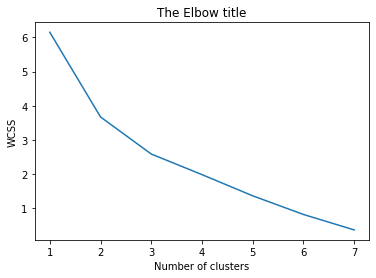

In [39]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot


wcss=[]
max_k = 8

for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(umap_embed_comments_array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    number_clusters = range(1, max_k)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [40]:
#run kmeans with no. of clusters you see fit the most
k = 3
kmeans = KMeans(n_clusters = k, n_init=10)
kmeans.fit(umap_embed_comments_array)
df['KMeans ID'] = kmeans.labels_

d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [41]:
#merge all reviews of each cluster into one big sentence
df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['comment'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

In [42]:
df_kmeans

,KMeans ID,texts
0,0,0 ซีฟู้ดร้านนี้ถือว่าสดมากมาแบบชิ้นโตๆ เต็ม...
1,1,2 มาอีกครั้งเพราะมีเมนูใหม่ Hotpot ชุดนี้ 2...
2,2,3 มื้อกลางวันแบบครอบครัวรับตรุษจีน หรือเพื่...


In [43]:
#create regex compiler for removal of a character you don't want
special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

In [44]:
#create regex compiler for removal of any emoji
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F" # emoticons
u"\U0001F300-\U0001F5FF" # symbols & pictographs
u"\U0001F680-\U0001F6FF" # transport & map symbols
u"\U0001F1E0-\U0001F1FF" # flags (iOS)
"]+", flags=re.UNICODE)

#create regex compiler for removal of digit
number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space
space_pattern = re.compile("\s+")
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

In [46]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ร้าน']
screening_words = stopwords + removed_words

#new_words = {''}

# words = new_words.union(thai_words())
# custom_dictionary_trie = Trie(words)

In [47]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
def tokenize_to_list(sentence):
    merged = []
    words = pythainlp.word_tokenize(str(sentence), engine='deepcut')

    for word in words:
        if word not in screening_words:
            merged.append(word)
    return merged

In [48]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x:collections.Counter(x).most_common())

3/3 [==============================] - 0s 13ms/step


In [49]:
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,ซีฟู้ดร้านนี้ถือว่าสดมากมาแบบชิ้นโตๆเต็มปากเตต...,"[ซีฟู้ดร้าน, สด, ชิ้น, เต็ม, ปาก, เต, กิน, กุ้...","[(สิงคโปร์, 2), (ซีฟู้ดร้าน, 1), (สด, 1), (ชิ้..."
1,1,มาอีกครั้งเพราะมีเมนูใหม่Hotpotชุดนี้++ร้านJum...,"[เมนู, Hotpot, ชุด, JumboSeafood, บูท, พารากอน...","[(เมนู, 1), (Hotpot, 1), (ชุด, 1), (JumboSeafo..."
2,2,มื้อกลางวันแบบครอบครัวรับตรุษจีนหรือเพื่อนฝูงส...,"[มื้อ, กลาง, ครอบครัว, ตรุษ, จีน, เพื่อนฝูง, ส...","[(มื้อ, 2), (!, 2), (กลาง, 1), (ครอบครัว, 1), ..."


In [50]:
# show top key word of each cluster

top_n_words = 10
for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_n_words]}\n")

Cluster ID : 0

Most common words include : [('สิงคโปร์', 2), ('ซีฟู้ดร้าน', 1), ('สด', 1), ('ชิ้น', 1), ('เต็ม', 1), ('ปาก', 1), ('เต', 1), ('กิน', 1), ('กุ้ง', 1), ('ทอดซีเรียล', 1)]

Cluster ID : 1

Most common words include : [('เมนู', 1), ('Hotpot', 1), ('ชุด', 1), ('JumboSeafood', 1), ('บูท', 1), ('พารากอน', 1), ('บริเวณ', 1), ('หน้', 1), ('อาหาร', 1), ('ซีฟู๊ด', 1)]

Cluster ID : 2

Most common words include : [('มื้อ', 2), ('!', 2), ('กลาง', 1), ('ครอบครัว', 1), ('ตรุษ', 1), ('จีน', 1), ('เพื่อนฝูง', 1), ('สิงคโปร์', 1), ('มิตร', 1), ('สหาย', 1)]



In [52]:
#clustering using agglomorative clustering
knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(
linkage="average", connectivity=knn_graph, n_clusters=8, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [53]:
#merge all reviews of each cluster into one big sentence
df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])
for i in range(0, k):
    row = []
    row.append(i)
    row.append(str(df['comment'][df['Agglomerative ID'] == i].tolist()))
    df_Agglomerative.loc[len(df_Agglomerative)] = row

In [54]:

#clean and tokenize sentences. count the occurences of each word
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x:
collections.Counter(x).most_common())

10/10 [==============================] - 3s 33ms/step


In [55]:
#show top keywords of each cluster
top_N_words = 10
for i in range(0, len(df_Agglomerative)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include :{list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include :[('ปู', 5), ('เมนู', 3), ('ผัด', 3), ('ดี', 3), ('รสชาติ', 3), ("'", 2), ('จัมโบ้', 2), ('หมู', 2), ('[', 1), ('อาหาร', 1)]

Cluster ID : 1

Most common words include :[("'", 2), ('สิงคโปร์', 2), ('!', 2), ('ดี', 2), ('[', 1), ('มื้อ', 1), ('มิตร', 1), ('สหาย', 1), ('วน', 1), ('จีน', 1)]

Cluster ID : 2

Most common words include :[("'", 2), ('ทาน', 2), ('สด', 2), ('เมนู', 2), ('ปลา', 2), ('ทอด', 2), ('[', 1), ('อาหาร', 1), ('เจ้าดัง', 1), ('สิงคโปร์', 1)]

